# **Modelamiento**

## Librerías

In [ ]:
!pip install scikit-learn==0.24.2

In [ ]:
!pip install unidecode

In [ ]:
#Generales
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Proceso de Modelación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,median_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

## Lectura Información

In [ ]:
#Descargar datasets desde github
!git clone https://github.com/andres-soto-h/monografia-udea-eacd.git

fatal: destination path 'monografia-udea-eacd' already exists and is not an empty directory.


In [ ]:
#Lectura del dataset transformado
df_propiedades=pd.read_csv('/content/monografia-udea-eacd/df_prop_clean_12082021.csv', delimiter=';', encoding='latin1')

In [ ]:
df_propiedades.rename(columns={"municipio":"ubicacion"}, inplace=True)

**NOTA:** se decide eliminar la información del municipio de **La Unión**.

In [ ]:
mask_union = df_propiedades['ubicacion']!='la uniÃ³n'
df_propiedades = df_propiedades[mask_union]

In [ ]:
df_propiedades['ubicacion'].value_counts()

rionegro                  1241
el retiro                  439
la ceja                    342
guarne                     196
marinilla                  117
el carmen de viboral        62
san antonio de pereira      38
llanogrande                 31
santuario                   15
Name: ubicacion, dtype: int64

**Nota2:** Se convierte la variable Estrato en ordinal

In [ ]:
df_propiedades['estrato'] = df_propiedades['estrato'].replace('Campestre', '0')
df_propiedades['estrato'] = df_propiedades['estrato'].astype(int)
df_propiedades['estrato'].value_counts()

4    947
5    636
3    584
0    162
6     89
2     58
1      5
Name: estrato, dtype: int64

## **Ajuste del Modelo**

**Funciones**

In [ ]:
#Métricas datos transformados
def median_absolute_error2(y_true, y_pred):
  return median_absolute_error(np.expm1(y_true), np.expm1(y_pred))

def mean_squared_error2(y_true, y_pred):
  return mean_squared_error(np.expm1(y_true), np.expm1(y_pred), squared=False)


def mean_absolute_percentage_error2(y_true, y_pred):
  return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))
  
def r2_score2(y_true, y_pred):
  return r2_score(np.expm1(y_true), np.expm1(y_pred))

In [ ]:
def div_train_test(X, y, var_stratify = ''):
  
  if var_stratify != '': 
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9, stratify = X[var_stratify],  random_state = 42)

    var_stratify_train = x_train[var_stratify]
    #ubicacion_test = X_test['ubicacion']

    x_train.drop(var_stratify,axis=1, inplace=True)
    x_test.drop(var_stratify,axis=1, inplace=True)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)

    return x_train, x_test, y_train, y_test, y_train_t, y_test_t, var_stratify_train

  else:
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9,  random_state = 42)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)
  
  return x_train, x_test, y_train, y_test, y_train_t, y_test_t

def busqueda_hiperparametros(x_train, y_train, var_stratify_train, estimator,param_grid = [] , scoring_med = 'neg_median_absolute_error', transf=False):

  if len(var_stratify_train) != 0:
    
    print('Seccion Stratify')
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
    stratified = sss.split(x_train, var_stratify_train)
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, cv = stratified, scoring = scoring_grid , refit = 'metrica',  return_train_score=True, n_jobs=-1, verbose=8)
    return grid.fit(x_train, y_train)
  
  else:
    print('OutStratify')
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, scoring = scoring_grid, refit = 'metrica', return_train_score=True, n_jobs=-1, verbose=8 )
    return grid.fit(X_train, y_train)

def metricas(model,y_train, p_train, y_test, p_test): 

  resultados = {
      'parametros' : [model.get_params()['steps'][1][1]],
      'MeAE_train' : [median_absolute_error(y_train,p_train)],
      'MeAE_test'  : [median_absolute_error(y_test, p_test)],
      'MAPE_train' : [mean_absolute_percentage_error(y_train,p_train)],
      'MAPE_test'  : [mean_absolute_percentage_error(y_test, p_test)],
      'r2_train'   : [r2_score(y_train,p_train)],
      'r2_test'    : [r2_score(y_test, p_test)],
      'rmse_train' : [mean_squared_error(y_train,p_train,squared = False)],
      'rmse_test'  : [mean_squared_error(y_test,p_test,squared = False)]
  }
  return pd.DataFrame(resultados)

**División Covariables  y Variable Objetivo**

In [ ]:
data_model=df_propiedades.copy()
#columnas_quitar=['tipo','url','titulo','descripcion','caractint','caractext','caractsec']
columnas_quitar=['url','titulo','descripcion','caractint','caractext','caractsec','otros_datos']
data_model.drop(columnas_quitar, axis=1, inplace=True)
data_model.shape

(2481, 177)

**OneHotEncoder Variables Categóricas**

In [ ]:
X = data_model.drop(['precio'], axis=1)
y = data_model['precio']

enc = OneHotEncoder(handle_unknown='ignore')
data_aux = pd.DataFrame(enc.fit_transform(X[['tipo','tipo_propiedad','ubicacion','antiguedad']]).toarray(), columns= enc.get_feature_names(['tipo','tipo_propiedad','ubicacion','antiguedad']))
data_aux['fila'] = range(0, X.shape[0])
data_aux.head()

X.drop(['tipo','tipo_propiedad','antiguedad'],axis=1,inplace=True)
X['fila'] = range(0, X.shape[0])

X = pd.merge(data_aux,X, on = 'fila', how='inner')
X.drop(['fila'], axis=1, inplace=True)
X.shape

(2481, 194)

**División train y Test**

In [ ]:
X_train, X_test, Y_train, Y_test, Y_train_t, Y_test_t, var_stratify_train = div_train_test(X, y, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### **Random Forest**

####**Sin transformar la Y**

In [ ]:
pipe_rf = Pipeline(steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42,n_estimators=150, max_depth=9, min_samples_split=4,min_samples_leaf=4    ))])
modelo_rf = pipe_rf.fit(X_train, Y_train)
modelo_rf['rf']

RandomForestRegressor(max_depth=9, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=150, random_state=42)

In [ ]:
metricas_rf = metricas(modelo_rf,Y_train, modelo_rf.predict(X_train), Y_test, modelo_rf.predict(X_test))
metricas_rf

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"(DecisionTreeRegressor(max_depth=9, max_featur...",5.348362e+07,7.340018e+07,0.163045,0.220709,0.893049,0.771647,1.845402e+08,3.046399e+08


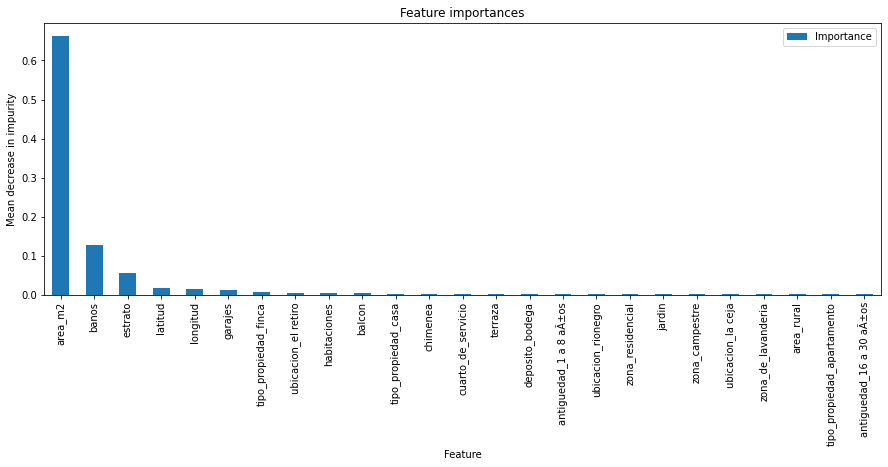

In [ ]:
importances = modelo_rf['rf'].feature_importances_
labels= list(X.columns)

data2 = zip(labels, importances)


rf_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=rf_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [ ]:
imp_zero = rf_importances[rf_importances['Importance']<=0]
print(imp_zero.shape)
col_zero = imp_zero['Feature'].tolist()
col_zero

(58, 2)


['cuarto_de_conductores',
 'con_casa_club',
 'oficinas_administrativas',
 'finca_agricola',
 'finca_agroganadera',
 'corrales',
 'cableado_de_red',
 'pasaje_comercial',
 'finca_ganadera',
 'puerta_de_seguridad',
 'cuarto_de_escoltas',
 'jaula_de_golf',
 'con_cerca_electrica',
 'mezzanine',
 'piso_en_alfombra',
 'esquinero',
 'acceso_para_camiones',
 'auditorio',
 'finca_avicola',
 'cocineta',
 'en_club',
 'con_casa_prefabricada',
 'patio_interno',
 'cuarto_de_servicio.1',
 'panoramica_un_lado',
 'salon_de_videoconferencias',
 'cancha_de_baloncesto',
 'servicios_independientes',
 'en_zona_comercial',
 'planta_electrica',
 'en_condominio',
 'piso_en_cemento',
 'piso_de_alta_resistencia',
 'establo',
 'lote_en_construccion',
 'bano_compartido',
 'zona_industrial',
 'ascensores_comunales',
 'jardines_exteriores',
 'alarma_contra_incendio',
 'deteccion_de_humo',
 'disponibilidad_wifi',
 'galpon',
 'control_de_acceso_digital',
 'pesebrera',
 'oficina_de_negocios',
 'invernadero',
 'sala_de_i

In [ ]:
X_imp = X.drop(col_zero, axis=1)
y_imp = y
X_imp.shape, y_imp.shape

((2481, 136), (2481,))

In [ ]:
X_train_imp, X_test_imp, Y_train_imp, Y_test_imp, Y_train_t_imp, Y_test_t_imp, var_stratify_train_imp = div_train_test(X_imp, y_imp, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
para_grid = {'rf__n_estimators':[100,120,150], 'rf__max_depth':[6,7,8,9], 'rf__min_samples_split':[4,5,6], 'rf__min_samples_leaf':[2,3,4]}

modelo_rf_imp = busqueda_hiperparametros(X_train_imp, Y_train_imp,var_stratify_train_imp, pipe_rf, param_grid = para_grid )

Seccion Stratify
**para datos sin transformar**
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
modelo_rf_imp.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=9, min_samples_leaf=3,
                                       min_samples_split=4, n_estimators=150,
                                       random_state=42))])

In [ ]:
metricas_rf_imp = metricas(modelo_rf_imp.best_estimator_,Y_train_imp, modelo_rf_imp.predict(X_train_imp), Y_test_imp, modelo_rf_imp.predict(X_test_imp))
metricas_rf_imp

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"(DecisionTreeRegressor(max_depth=9, max_featur...",5.276573e+07,7.008928e+07,0.156914,0.218941,0.906257,0.778407,1.727704e+08,3.000975e+08


####**Usando Y transformada**

In [ ]:
pipe_rft = Pipeline(steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42,n_estimators=120, max_depth=9, min_samples_split=5,min_samples_leaf=2))])
modelo_rft = pipe_rft.fit(X_train, Y_train_t)
modelo_rft['rf']

RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=120, random_state=42)

In [ ]:
metricas_rf_t = metricas(modelo_rft,Y_train, np.expm1(modelo_rft.predict(X_train)), Y_test, np.expm1(modelo_rft.predict(X_test)))
metricas_rf_t

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"(DecisionTreeRegressor(max_depth=9, max_featur...",4.630985e+07,7.502619e+07,0.135886,0.205783,0.886589,0.743525,1.900325e+08,3.228539e+08


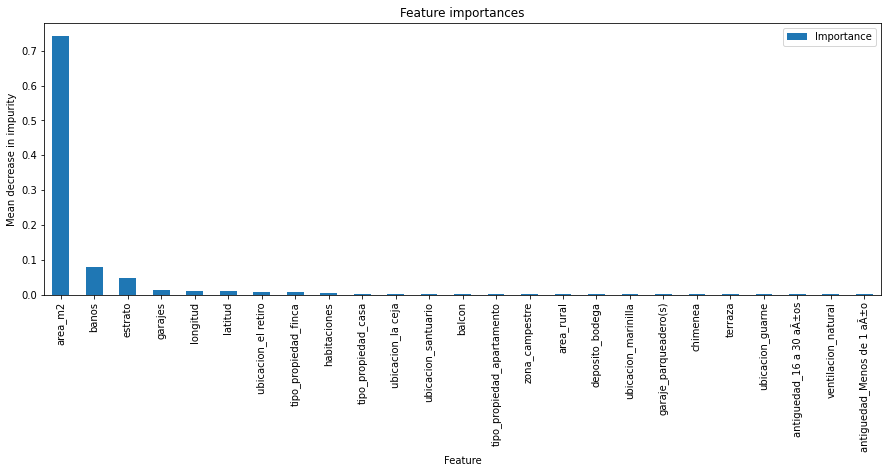

In [ ]:
importances = modelo_rft['rf'].feature_importances_
labels= list(X.columns)

data2 = zip(labels, importances)


rft_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=rft_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [ ]:
imp_zero = rf_importances[rf_importances['Importance']<=0]
print(imp_zero.shape)
col_zero = imp_zero['Feature'].tolist()
col_zero

(58, 2)


['cuarto_de_conductores',
 'con_casa_club',
 'oficinas_administrativas',
 'finca_agricola',
 'finca_agroganadera',
 'corrales',
 'cableado_de_red',
 'pasaje_comercial',
 'finca_ganadera',
 'puerta_de_seguridad',
 'cuarto_de_escoltas',
 'jaula_de_golf',
 'con_cerca_electrica',
 'mezzanine',
 'piso_en_alfombra',
 'esquinero',
 'acceso_para_camiones',
 'auditorio',
 'finca_avicola',
 'cocineta',
 'en_club',
 'con_casa_prefabricada',
 'patio_interno',
 'cuarto_de_servicio.1',
 'panoramica_un_lado',
 'salon_de_videoconferencias',
 'cancha_de_baloncesto',
 'servicios_independientes',
 'en_zona_comercial',
 'planta_electrica',
 'en_condominio',
 'piso_en_cemento',
 'piso_de_alta_resistencia',
 'establo',
 'lote_en_construccion',
 'bano_compartido',
 'zona_industrial',
 'ascensores_comunales',
 'jardines_exteriores',
 'alarma_contra_incendio',
 'deteccion_de_humo',
 'disponibilidad_wifi',
 'galpon',
 'control_de_acceso_digital',
 'pesebrera',
 'oficina_de_negocios',
 'invernadero',
 'sala_de_i

In [ ]:
X_imp = X.drop(col_zero, axis=1)
y_imp = y
X_imp.shape, y_imp.shape

((2481, 136), (2481,))

**Búsqueda de Hiperparámetros**

In [ ]:
# para_grid = {'rf__n_estimators':[80,100,120,150], 'rf__max_depth':[3,5,10,20,25], 'rf__min_samples_split':[2,3,5,10,15],'rf__min_samples_leaf':[1,2,5,8]}
X_train_imp, X_test_imp, Y_train_imp, Y_test_imp, Y_train_t_imp, Y_test_t_imp, var_stratify_train_imp = div_train_test(X_imp, y_imp, var_stratify = 'ubicacion')
para_grid = {'rf__n_estimators':[100,120,150], 'rf__max_depth':[6,7,8,9], 'rf__min_samples_split':[4,5,6], 'rf__min_samples_leaf':[2,3,4]}

modelo_rf_t_imp = busqueda_hiperparametros(X_train_imp, Y_train_t_imp,var_stratify_train, pipe_rft, param_grid = para_grid, transf = True)
modelo_rf_t_imp

Seccion Stratify
**para datos transformados**
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f6be07f0cd0>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(max_depth=9,
                                                              min_samples_leaf=2,
                                                              min_samples_split=5,
                                                              n_estimators=120,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [6, 7, 8, 9],
                         'rf__min_samples_leaf': [2, 3, 4],
                         'rf__min_samples_split': [4, 5, 6],
                         'rf__n_estimators': [100, 120, 150]},
             refit='metrica', return_train_score=True,
             scoring={'mape': make_scorer(mean_absolute_percentage_error2),
          

In [ ]:
metricas_rft_imp = metricas(modelo_rf_t_imp.best_estimator_,Y_train_imp, np.expm1(modelo_rf_t_imp.predict(X_train_imp)), Y_test_imp, np.expm1(modelo_rf_t_imp.predict(X_test_imp)))
metricas_rft_imp

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"(DecisionTreeRegressor(max_depth=9, max_featur...",4.532903e+07,7.488465e+07,0.135613,0.204811,0.88636,0.746431,1.902236e+08,3.210199e+08


In [ ]:
modelo_rf_t_imp.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=9, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=150,
                                       random_state=42))])

### **Gradient Boosting Regression**

####**Sin tranformar la Y**

In [ ]:
pipe_gbt = Pipeline(steps = [('scaler', StandardScaler()), ('gbt', GradientBoostingRegressor(random_state=42,n_estimators=150, max_depth=9, min_samples_split=4,min_samples_leaf=3  ))])
modelo_gbt = pipe_gbt.fit(X_train, Y_train)
modelo_gbt['gbt']

GradientBoostingRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=4,
                          n_estimators=150, random_state=42)

In [ ]:
metricas_gbt = metricas(modelo_gbt,Y_train, modelo_gbt.predict(X_train), Y_test, modelo_gbt.predict(X_test))
metricas_gbt

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,([DecisionTreeRegressor(criterion='friedman_ms...,7.774991e+06,7.417244e+07,0.02737,0.206195,0.998624,0.785648,2.092951e+07,2.951534e+08


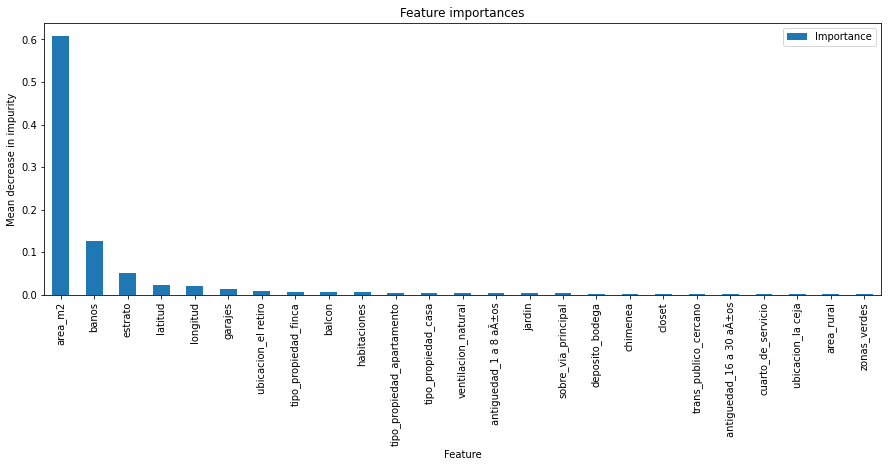

In [ ]:
importances = modelo_gbt['gbt'].feature_importances_
labels= list(X.columns)

data2 = zip(labels, importances)


gbt_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=gbt_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [ ]:
imp_zero = gbt_importances[gbt_importances['Importance']<=0]
print(imp_zero.shape)
col_zero = imp_zero['Feature'].tolist()
col_zero

(49, 2)


['con_casa_prefabricada',
 'finca_agroganadera',
 'en_club',
 'cableado_de_red',
 'pasaje_comercial',
 'oficina_de_negocios',
 'planta_electrica',
 'mezzanine',
 'esquinero',
 'acceso_para_camiones',
 'cuarto_de_escoltas',
 'salon_de_videoconferencias',
 'oficinas_administrativas',
 'con_cerca_electrica',
 'jaula_de_golf',
 'piso_en_alfombra',
 'auditorio',
 'finca_avicola',
 'patio_interno',
 'cocineta',
 'panoramica_un_lado',
 'sensor_de_movimiento',
 'industrial',
 'corrales',
 'finca_ganadera',
 'en_edificio',
 'piso_de_alta_resistencia',
 'alarma_contra_incendio',
 'deteccion_de_humo',
 'lic_de_construccion',
 'locales_comerciales',
 'ubicada_en_edificio',
 'disponibilidad_wifi',
 'en_zona_comercial',
 'piso_en_cemento',
 'con_administrador',
 'invernadero',
 'ascensores_comunales',
 'lote_en_construccion',
 'con_vivienda',
 'escalera_de_emergencia',
 'gabinete_de_incendios',
 'ascensor(es)_inteligente(s)',
 'jardines_exteriores',
 'banos_comunales',
 'banos_mixtos',
 'servicios_i

In [ ]:
X_imp = X.drop(col_zero, axis=1)
y_imp = y
X_imp.shape, y_imp.shape

X_train_imp, X_test_imp, Y_train_imp, Y_test_imp, Y_train_t_imp, Y_test_t_imp, var_stratify_train_imp = div_train_test(X_imp, y_imp, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Búsqueda de Hiperparámetros**

In [ ]:
para_grid = {'gbt__n_estimators':[100,120,150], 'gbt__max_depth':[6,7,8,9], 'gbt__min_samples_split':[4,5,6], 'gbt__min_samples_leaf':[2,3,4]}

modelo_gbt_imp = busqueda_hiperparametros(X_train_imp, Y_train_imp,var_stratify_train_imp, pipe_gbt, param_grid = para_grid )

Seccion Stratify
**para datos sin transformar**
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
metricas_gbt_imp = metricas(modelo_gbt_imp.best_estimator_,Y_train_imp, modelo_gbt_imp.predict(X_train_imp), Y_test_imp, modelo_gbt_imp.predict(X_test_imp))
metricas_gbt_imp

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,([DecisionTreeRegressor(criterion='friedman_ms...,1.286029e+07,7.518294e+07,0.040285,0.205959,0.996819,0.7842,3.182563e+07,2.961483e+08


In [ ]:
modelo_gbt_imp.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbt',
                 GradientBoostingRegressor(max_depth=9, min_samples_leaf=3,
                                           min_samples_split=4,
                                           random_state=42))])

####**Usando Y transformada**

In [ ]:
pipe_gbtt = Pipeline(steps = [('scaler', StandardScaler()), ('gbt', GradientBoostingRegressor(random_state=42,n_estimators=120, max_depth=9, min_samples_split=4,min_samples_leaf=4))])
modelo_gbtt = pipe_gbtt.fit(X_train, Y_train_t)
modelo_gbtt['gbt']

GradientBoostingRegressor(max_depth=9, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=120, random_state=42)

In [ ]:
metricas_gbt_t = metricas(modelo_gbtt,Y_train, np.expm1(modelo_gbtt.predict(X_train)), Y_test, np.expm1(modelo_gbtt.predict(X_test)))
metricas_gbt_t

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,([DecisionTreeRegressor(criterion='friedman_ms...,9.519395e+06,7.527124e+07,0.028575,0.189862,0.994003,0.790916,4.369992e+07,2.915036e+08


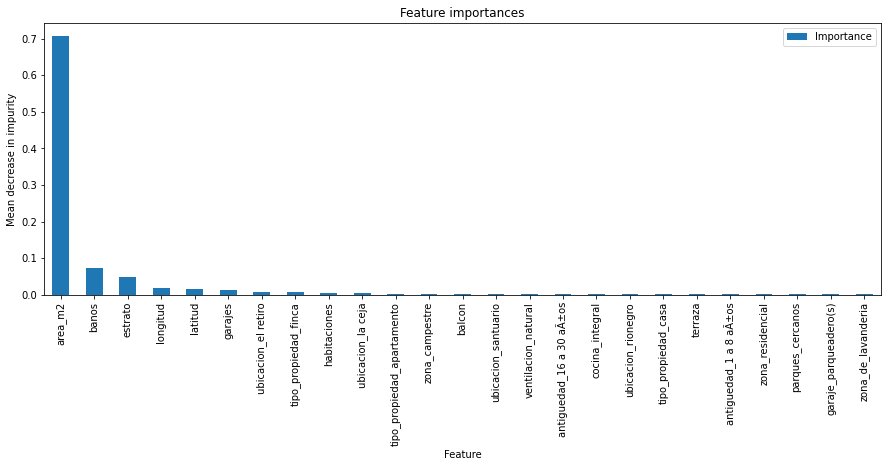

In [ ]:
importances = modelo_gbtt['gbt'].feature_importances_
labels= list(X.columns)

data2 = zip(labels, importances)


gbtt_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=gbtt_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [ ]:
imp_zero = gbtt_importances[gbtt_importances['Importance']<=0]
print(imp_zero.shape)
col_zero = imp_zero['Feature'].tolist()
col_zero

(56, 2)


['corrales',
 'con_casa_club',
 'esquinero',
 'cableado_de_red',
 'con_casa_prefabricada',
 'finca_agroganadera',
 'finca_agricola',
 'mezzanine',
 'cuarto_de_conductores',
 'piso_en_alfombra',
 'en_club',
 'jaula_de_golf',
 'acceso_para_camiones',
 'sensor_de_movimiento',
 'auditorio',
 'pasaje_comercial',
 'salon_de_videoconferencias',
 'oficinas_administrativas',
 'patio_interno',
 'cuarto_de_servicio.1',
 'con_cerca_electrica',
 'cuarto_de_escoltas',
 'panoramica_un_lado',
 'cocineta',
 'finca_ganadera',
 'finca_avicola',
 'oficina_de_negocios',
 'rociadores_de_agua',
 'disponibilidad_wifi',
 'piso_en_cemento',
 'piso_de_alta_resistencia',
 'lote_en_construccion',
 'ascensores_comunales',
 'con_administrador',
 'alcantarillado',
 'ubicada_en_edificio',
 'jardines_exteriores',
 'alarma_contra_incendio',
 'deteccion_de_humo',
 'lic_de_construccion',
 'locales_comerciales',
 'en_zona_comercial',
 'servicios_independientes',
 'galpon',
 'cancha_de_baloncesto',
 'planta_electrica',
 'si

In [ ]:
X_imp = X.drop(col_zero, axis=1)
y_imp = y
X_imp.shape, y_imp.shape

((2481, 138), (2481,))

**Búsqueda de hiperparámetros**

In [ ]:
# para_grid = {'rf__n_estimators':[80,100,120,150], 'rf__max_depth':[3,5,10,20,25], 'rf__min_samples_split':[2,3,5,10,15],'rf__min_samples_leaf':[1,2,5,8]}
X_train_imp, X_test_imp, Y_train_imp, Y_test_imp, Y_train_t_imp, Y_test_t_imp, var_stratify_train_imp = div_train_test(X_imp, y_imp, var_stratify = 'ubicacion')
para_grid = {'gbt__n_estimators':[100,120,150], 'gbt__max_depth':[6,7,8,9], 'gbt__min_samples_split':[4,5,6], 'gbt__min_samples_leaf':[2,3,4]}
modelo_gbt_t_imp = busqueda_hiperparametros(X_train_imp, Y_train_t_imp,var_stratify_train, pipe_gbtt, param_grid = para_grid, transf = True)
modelo_gbt_t_imp

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Seccion Stratify
**para datos transformados**
Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f6be03afb50>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbt',
                                        GradientBoostingRegressor(max_depth=9,
                                                                  min_samples_leaf=4,
                                                                  min_samples_split=4,
                                                                  n_estimators=120,
                                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'gbt__max_depth': [6, 7, 8, 9],
                         'gbt__min_samples_leaf': [2, 3, 4],
                         'gbt__min_samples_split': [4, 5, 6],
                         'gbt__n_estimators': [100, 120, 150]},
             refit='metrica', return_train_score=True,
             scoring={'mape': make_scorer(mean_absolute_perce

In [ ]:
metricas_gbt_t_imp = metricas(modelo_gbt_t_imp.best_estimator_,Y_train_imp, np.expm1(modelo_gbt_t_imp.predict(X_train_imp)), Y_test_imp, np.expm1(modelo_gbt_t_imp.predict(X_test_imp)))
metricas_gbt_t_imp

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,([DecisionTreeRegressor(criterion='friedman_ms...,1.065987e+07,7.532039e+07,0.032538,0.192684,0.991629,0.792178,5.162952e+07,2.906230e+08


In [ ]:
modelo_gbt_t_imp.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbt',
                 GradientBoostingRegressor(max_depth=9, min_samples_leaf=4,
                                           min_samples_split=4,
                                           random_state=42))])

### **XG Boost**

#### Sin transformar la Y

In [ ]:
import xgboost as xgb
pipe_xgb = pipe_xgb = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('xgb',  xgb.XGBRegressor(
        objective='reg:squarederror', n_jobs=-1, max_depth=6,reg_alpha=0.01
    ))
])
modelo_xgb = pipe_xgb.fit(X_train, Y_train)
modelo_xgb['xgb']

XGBRegressor(max_depth=6, n_jobs=-1, objective='reg:squarederror',
             reg_alpha=0.01)

In [ ]:
metricas_xgb = metricas(modelo_xgb,Y_train, modelo_xgb.predict(X_train), Y_test, modelo_xgb.predict(X_test))
metricas_xgb

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"XGBRegressor(max_depth=6, n_jobs=-1, objective...",43208272.0,85208512.0,0.118753,0.21386,0.961429,0.783696,1.108224e+08,2.964941e+08


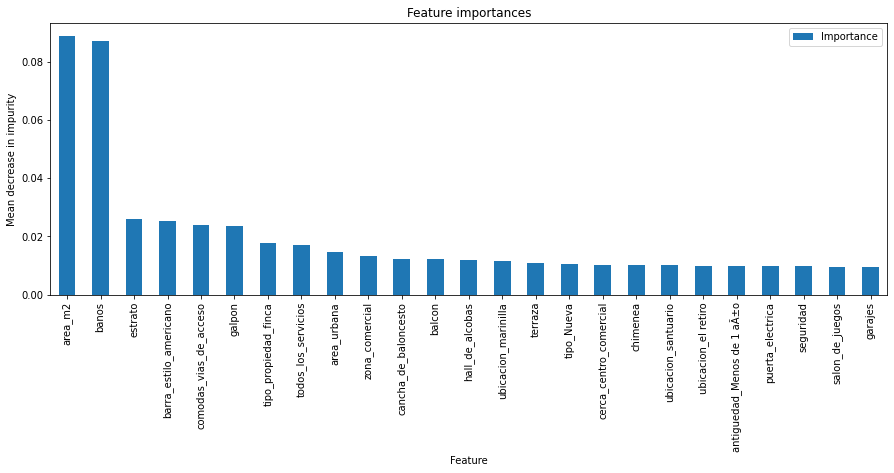

In [ ]:
importances = modelo_xgb['xgb'].feature_importances_
labels= list(X.columns)

data2 = zip(labels, importances)


xgb_importances = pd.DataFrame(data2, columns=['Feature','Importance']).sort_values(by=['Importance'], ascending=False)
most_important=xgb_importances.iloc[:25,:]
most_important.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(15,5))
most_important.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [ ]:
imp_zero = xgb_importances[xgb_importances['Importance']<=0]
print(imp_zero.shape)
col_zero = imp_zero['Feature'].tolist()
col_zero

(55, 2)


['auditorio',
 'sensor_de_movimiento',
 'acceso_para_camiones',
 'esquinero',
 'con_casa_club',
 'finca_agricola',
 'mezzanine',
 'piso_de_alta_resistencia',
 'puerta_de_seguridad',
 'cableado_de_red',
 'finca_agroganadera',
 'patio_interno',
 'locales_comerciales',
 'cuarto_de_servicio.1',
 'parqueadero_interno',
 'corrales',
 'cocineta',
 'finca_avicola',
 'piso_en_alfombra',
 'jaula_de_golf',
 'con_cerca_electrica',
 'oficinas_administrativas',
 'salon_de_videoconferencias',
 'pasaje_comercial',
 'en_club',
 'con_casa_prefabricada',
 'panoramica_un_lado',
 'servicios_independientes',
 'finca_ganadera',
 'con_vivienda',
 'disponibilidad_wifi',
 'en_zona_comercial',
 'deteccion_de_humo',
 'alarma_contra_incendio',
 'jardines_exteriores',
 'en_zona_residencial',
 'ubicada_en_edificio',
 'con_administrador',
 'sala_de_internet',
 'ascensores_comunales',
 'tipo_Usada',
 'oficina_de_negocios',
 'rociadores_de_agua',
 'aire_acondicionado',
 'bahia_exterior_de_parqueo',
 'escalera_de_emerge

**Búsqueda de Hiperparámetros**

In [ ]:
X_imp = X.drop(col_zero, axis=1)
y_imp = y
X_imp.shape, y_imp.shape

X_train_imp, X_test_imp, Y_train_imp, Y_test_imp, Y_train_t_imp, Y_test_t_imp, var_stratify_train_imp = div_train_test(X_imp, y_imp, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
para_grid = { 'xgb__max_depth':[5,6], 'xgb__learning_rate':[0.05,0.1], 'xgb__reg_alpha':[0.01,0.5,0.1]}
#'xgb__n_estimators':[100,120,150],
modelo_xgb_imp = busqueda_hiperparametros(X_train_imp, Y_train_imp,var_stratify_train_imp, pipe_xgb, param_grid = para_grid )

Seccion Stratify
**para datos sin transformar**
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
metricas_xgb_imp = metricas(modelo_xgb_imp.best_estimator_,Y_train_imp, modelo_xgb_imp.predict(X_train_imp), Y_test_imp, modelo_xgb_imp.predict(X_test_imp))
metricas_xgb_imp

,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,"XGBRegressor(max_depth=6, n_jobs=-1, objective...",43208272.0,85208512.0,0.118753,0.21386,0.961429,0.783696,1.108224e+08,2.964941e+08


In [ ]:
modelo_xgb_imp.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(max_depth=6, n_jobs=-1,
                              objective='reg:squarederror', reg_alpha=0.01))])

## Resumen

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/Seminario/Etapa Modelamiento/Resultados'

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/Seminario/Etapa Modelamiento/Resultados


In [ ]:
import os
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Seminario/Etapa Modelamiento/Resultados'

In [ ]:
cross_validation_rf_imp = pd.DataFrame(modelo_rf_imp.cv_results_)
cross_validation_rf_imp = cross_validation_rf_imp[cross_validation_rf_imp['rank_test_metrica']==1][['params','mean_test_metrica', 'std_test_metrica','mean_train_metrica', 'std_train_metrica','mean_train_meae','mean_test_meae','mean_train_mape','mean_test_mape','mean_train_r2','mean_test_r2','mean_train_rmse','mean_test_rmse']]
cross_validation_rf_imp['escenario']='modelo_rf'

cross_validation_rft_imp=pd.DataFrame(modelo_rf_t_imp.cv_results_)
cross_validation_rft_imp = cross_validation_rft_imp[cross_validation_rft_imp['rank_test_metrica']==1][['params','mean_test_metrica', 'std_test_metrica','mean_train_metrica', 'std_train_metrica','mean_train_meae','mean_test_meae','mean_train_mape','mean_test_mape','mean_train_r2','mean_test_r2','mean_train_rmse','mean_test_rmse']]
cross_validation_rft_imp['escenario']='modelo_rft'

cross_validation_gbt_imp=pd.DataFrame(modelo_gbt_imp.cv_results_)
cross_validation_gbt_imp = cross_validation_gbt_imp[cross_validation_gbt_imp['rank_test_metrica']==1][['params','mean_test_metrica', 'std_test_metrica','mean_train_metrica', 'std_train_metrica','mean_train_meae','mean_test_meae','mean_train_mape','mean_test_mape','mean_train_r2','mean_test_r2','mean_train_rmse','mean_test_rmse']]
cross_validation_gbt_imp['escenario']='modelo_gbt'

cross_validation_gbtt_imp=pd.DataFrame(modelo_gbt_t_imp.cv_results_)
cross_validation_gbtt_imp = cross_validation_gbtt_imp[cross_validation_gbtt_imp['rank_test_metrica']==1][['params','mean_test_metrica', 'std_test_metrica','mean_train_metrica', 'std_train_metrica','mean_train_meae','mean_test_meae','mean_train_mape','mean_test_mape','mean_train_r2','mean_test_r2','mean_train_rmse','mean_test_rmse']]
cross_validation_gbtt_imp['escenario']='modelo_gbtt'

cross_validation_xgb_imp=pd.DataFrame(modelo_xgb_imp.cv_results_)
cross_validation_xgb_imp = cross_validation_xgb_imp[cross_validation_xgb_imp['rank_test_metrica']==1][['params','mean_test_metrica', 'std_test_metrica','mean_train_metrica', 'std_train_metrica','mean_train_meae','mean_test_meae','mean_train_mape','mean_test_mape','mean_train_r2','mean_test_r2','mean_train_rmse','mean_test_rmse']]
cross_validation_xgb_imp['escenario']='modelo_xgb'


resultado_cross = pd.concat([cross_validation_rf_imp,cross_validation_rft_imp, cross_validation_gbt_imp, cross_validation_gbtt_imp,cross_validation_xgb_imp],
                            ignore_index = True)

columna = pd.DataFrame(resultado_cross['params'])

resultado_cross.drop(['params'],axis=1, inplace=True)
resultado_cross = resultado_cross.drop_duplicates()
resultado_cross.reset_index(inplace=True, drop=False)
resultado_cross

,index,mean_test_metrica,std_test_metrica,mean_train_metrica,std_train_metrica,mean_train_meae,mean_test_meae,mean_train_mape,mean_test_mape,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse,escenario
0,0,-7.141752e+07,7.298581e+06,-5.220625e+07,7.394426e+05,5.220625e+07,7.141752e+07,0.152606,0.228701,0.910148,0.731571,2.835601e+16,9.117422e+16,modelo_rf
1,3,-1.497248e-01,1.072751e-02,-9.410796e-02,1.975009e-03,4.499051e+07,7.206059e+07,0.131828,0.213607,0.890954,0.703036,1.854928e+08,3.174225e+08,modelo_rft
2,4,-6.300844e+07,9.028249e+06,-1.107124e+07,1.620728e+06,1.107124e+07,6.300844e+07,0.035941,0.214882,0.997612,0.718338,7.524227e+14,9.601096e+16,modelo_gbt
3,7,-1.299469e-01,5.147470e-03,-1.897814e-02,1.175725e-03,9.832416e+06,6.062635e+07,0.029926,0.198001,0.993606,0.716597,4.490131e+07,3.095956e+08,modelo_gbtt
4,10,-6.859777e+07,1.048831e+07,-3.968697e+07,8.182824e+05,3.968697e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb
5,11,-6.859777e+07,1.048831e+07,-3.968698e+07,8.182800e+05,3.968698e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb
6,12,-6.859777e+07,1.048831e+07,-3.968698e+07,8.182800e+05,3.968698e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb


In [ ]:
resultado_metricas = pd.concat([metricas_rf_imp, metricas_rft_imp, metricas_gbt_imp, metricas_gbt_t_imp, metricas_xgb_imp],
                            ignore_index = True)
resultado_metricas.drop_duplicates(inplace=True)
resultado_metricas.reset_index(inplace=True, drop=False)
resultado_metricas

,index,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test
0,0,"(DecisionTreeRegressor(max_depth=9, max_featur...",5.276573e+07,7.008928e+07,0.156914,0.218941,0.906257,0.778407,1.727704e+08,3.000975e+08
1,1,"(DecisionTreeRegressor(max_depth=9, max_featur...",4.532903e+07,7.488465e+07,0.135613,0.204811,0.886360,0.746431,1.902236e+08,3.210199e+08
2,2,([DecisionTreeRegressor(criterion='friedman_ms...,1.286029e+07,7.518294e+07,0.040285,0.205959,0.996819,0.784200,3.182563e+07,2.961483e+08
3,3,([DecisionTreeRegressor(criterion='friedman_ms...,1.065987e+07,7.532039e+07,0.032538,0.192684,0.991629,0.792178,5.162952e+07,2.906230e+08
4,4,"XGBRegressor(max_depth=6, n_jobs=-1, objective...",4.320827e+07,8.520851e+07,0.118753,0.213860,0.961429,0.783696,1.108224e+08,2.964941e+08


In [ ]:
resultados =  pd.concat([resultado_metricas, resultado_cross], axis=1)
resultados

,index,parametros,MeAE_train,MeAE_test,MAPE_train,MAPE_test,r2_train,r2_test,rmse_train,rmse_test,index,mean_test_metrica,std_test_metrica,mean_train_metrica,std_train_metrica,mean_train_meae,mean_test_meae,mean_train_mape,mean_test_mape,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse,escenario
0,0.0,"(DecisionTreeRegressor(max_depth=9, max_featur...",5.276573e+07,7.008928e+07,0.156914,0.218941,0.906257,0.778407,1.727704e+08,3.000975e+08,0,-7.141752e+07,7.298581e+06,-5.220625e+07,7.394426e+05,5.220625e+07,7.141752e+07,0.152606,0.228701,0.910148,0.731571,2.835601e+16,9.117422e+16,modelo_rf
1,1.0,"(DecisionTreeRegressor(max_depth=9, max_featur...",4.532903e+07,7.488465e+07,0.135613,0.204811,0.886360,0.746431,1.902236e+08,3.210199e+08,3,-1.497248e-01,1.072751e-02,-9.410796e-02,1.975009e-03,4.499051e+07,7.206059e+07,0.131828,0.213607,0.890954,0.703036,1.854928e+08,3.174225e+08,modelo_rft
2,2.0,([DecisionTreeRegressor(criterion='friedman_ms...,1.286029e+07,7.518294e+07,0.040285,0.205959,0.996819,0.784200,3.182563e+07,2.961483e+08,4,-6.300844e+07,9.028249e+06,-1.107124e+07,1.620728e+06,1.107124e+07,6.300844e+07,0.035941,0.214882,0.997612,0.718338,7.524227e+14,9.601096e+16,modelo_gbt
3,3.0,([DecisionTreeRegressor(criterion='friedman_ms...,1.065987e+07,7.532039e+07,0.032538,0.192684,0.991629,0.792178,5.162952e+07,2.906230e+08,7,-1.299469e-01,5.147470e-03,-1.897814e-02,1.175725e-03,9.832416e+06,6.062635e+07,0.029926,0.198001,0.993606,0.716597,4.490131e+07,3.095956e+08,modelo_gbtt
4,4.0,"XGBRegressor(max_depth=6, n_jobs=-1, objective...",4.320827e+07,8.520851e+07,0.118753,0.213860,0.961429,0.783696,1.108224e+08,2.964941e+08,10,-6.859777e+07,1.048831e+07,-3.968697e+07,8.182824e+05,3.968697e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,-6.859777e+07,1.048831e+07,-3.968698e+07,8.182800e+05,3.968698e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,-6.859777e+07,1.048831e+07,-3.968698e+07,8.182800e+05,3.968698e+07,6.859777e+07,0.110332,0.218300,0.967305,0.751769,1.032199e+16,8.486154e+16,modelo_xgb


In [ ]:
resultados.to_csv('resultados_train_test_general_importancia_var.csv',sep=";",decimal=",")